In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

def extract_article_metadata_list_from_sitemap(url, sitemap_number):
    """
    Iterates through a sitemap and for each url tag, extracts the URL, title, last modified timestamp, year, month, and day.
    Returns a list of dictionaries, each containing the extracted metadata.
    """
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch the sitemap. Status code: {response.status_code}")
        return []
    
    # find all url tags in the XML sitemap
    urls = []
    soup = BeautifulSoup(response.content, 'lxml-xml')
    for url_tag in soup.find_all('url'):
        loc_tag = url_tag.find('loc')
        lastmod_tag = url_tag.find('lastmod')
        
        # skip if <loc> is missing
        if loc_tag is None:
            continue
            
        loc_tag_text = loc_tag.text.strip()
        last_modified = lastmod_tag.text.strip() if lastmod_tag else None

        # infer report title from url
        title = loc_tag_text.replace("https://smallcaps.com.au", "").replace("-", " ").replace("/", "").capitalize()
        
        # convert last_modified to a datetime object
        lastmod_timestamp = None
        if last_modified:
            try:
                lastmod_timestamp = datetime.strptime(last_modified, '%Y-%m-%dT%H:%M:%S%z').timestamp()
            except Exception as e:
                print(f"Error parsing date {last_modified}: {e}")

        urls.append({
            "url": loc_tag_text,
            "sitemap_number": sitemap_number,
            "title": title,
            "last_modified_timestamp": lastmod_timestamp, 
            "last_modified_year": last_modified[:4] if last_modified else None,  # Year format
            "last_modified_month": last_modified[5:7] if last_modified else None,  # Month format
            "last_modified_day": last_modified[8:10] if last_modified else None  # Day format
        })
    
    return urls

is_article_url = lambda url: len(url) >= 50  # article titles tend to be long and are included in the url, so we can use this distinction to filter out non-article URLs

sitemap_count = 66
articles = []
for sitemap_number in range(1, sitemap_count + 1):
    print(f"Fetching sitemap {sitemap_number}")
    try:  # there are a list of sitemaps with the names part/1.xml, part/2.xml, we gather all urls from all sitemaps and append to articles list
        sitemap_sub_path = f'sitemap/part/{sitemap_number}.xml'
        article_metadata = extract_article_metadata_list_from_sitemap(f'https://smallcaps.com.au/{sitemap_sub_path}', sitemap_number)        
        article_metadata = list(filter(lambda url_data: is_article_url(url_data['url']), article_metadata))
        articles.extend(article_metadata)
    except Exception as e:
        print(f"Failed to fetch sitemap {sitemap_number}. Error: {e}")


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(articles)
df.to_csv('article_metadata.csv', index=False)


# Visualise the Article Collection

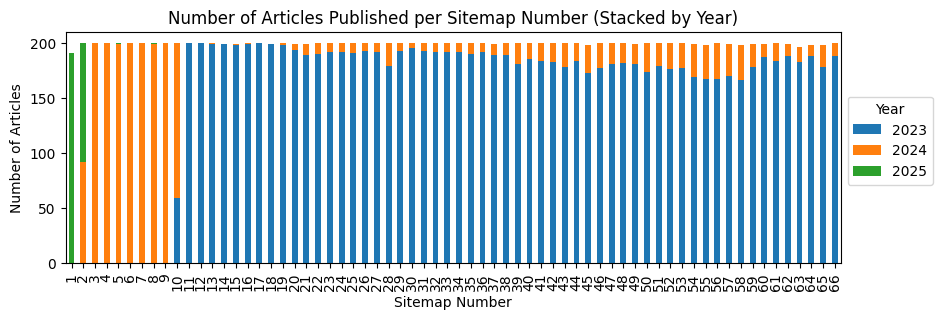

In [ ]:
pivot_df = df.pivot_table(index='sitemap_number', columns='last_modified_year', aggfunc='size', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 3))
plt.xlabel('Sitemap Number')
plt.ylabel('Number of Articles')
plt.title('Number of Articles Published per Sitemap Number (Stacked by Year)')
plt.legend(title='Year', bbox_to_anchor=(1, 0.75))
plt.show()

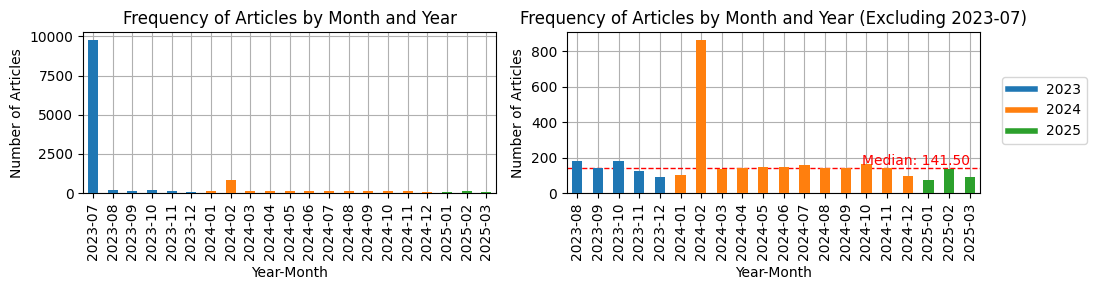

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

def color_bars_by_year(series):
    """
    series: a Pandas Series whose index is 'YYYY-MM' strings
    returns: a list of colors corresponding to each index (by year)
    """
    # Extract year from each 'YYYY-MM' index
    years = [idx.split('-')[0] for idx in series.index]

    # Define a color map for the years
    color_map = {'2023': '#1f77b4', '2024': '#ff7f0e', '2025': '#2ca02c'}
    
    # Return the list of colors corresponding to the year of each bar
    return [color_map[year] for year in years]

df['last_modified_year_month'] = df['last_modified_year'] + '-' + df['last_modified_month']
counts_all = df['last_modified_year_month'].value_counts().sort_index()

# Get a color list for the bars based on the year
bar_colors_all = color_bars_by_year(counts_all)

counts_all.plot(
    kind='bar',
    ax=axes[0],
    color=bar_colors_all,
    zorder=3
)

axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Number of Articles')
axes[0].set_title('Frequency of Articles by Month and Year')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, zorder=0)

df_filtered = df[df['last_modified_year_month'] != '2023-07']
counts_filtered = df_filtered['last_modified_year_month'].value_counts().sort_index()

bar_colors_filtered = color_bars_by_year(counts_filtered)

counts_filtered.plot(
    kind='bar',
    ax=axes[1],
    color=bar_colors_filtered,
    zorder=3
)

axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Number of Articles')
axes[1].set_title('Frequency of Articles by Month and Year (Excluding 2023-07)')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, zorder=0)

median_value = counts_filtered.median()
axes[1].axhline(median_value, color='r', linestyle='--', linewidth=1, zorder=2)
axes[1].text(
    x=len(counts_filtered) - 1,
    y=median_value,
    s=f'Median: {median_value:.2f}',
    color='r',
    va='bottom',
    ha='right'
)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in ['#1f77b4', '#ff7f0e', '#2ca02c']]
labels = ['2023', '2024', '2025']
fig.legend(handles, labels, loc = 'upper left',bbox_to_anchor=(1, 0.75))

plt.tight_layout()
plt.show()
